In [297]:
from langgraph.graph import START, END, StateGraph, MessagesState
from typing import TypedDict, Literal
from IPython.display import Image, display
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
load_dotenv()

True

In [303]:
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
)

In [250]:
class MyState(MessagesState):
    question: str
    itr: int
    quality: int

In [304]:
class CoderOutput(BaseModel):
    code: str = Field(description="Contains the code for the problem")

In [351]:
class ReviewerOutput(BaseModel):
    score: int = Field(description="Score to the given input out of 1000")
    comment: str = Field(description="Contains the relevant comment for the input")

In [352]:
coder_llm = llm.with_structured_output(schema=CoderOutput)

In [353]:
reviewer_llm = llm.with_structured_output(schema=ReviewerOutput)

In [354]:
def coder(state):
    try:
        print("------------ CODER START ------------")
        question = state["question"]
        sys_msg = SystemMessage(content='''You are an expert coder and your task is to write code based on the given question and output 
        the code in the code key''')
        human_msg = HumanMessage(content=f"Write me code for {question}")
        answer = coder_llm.invoke([sys_msg] + [human_msg])
        print("ANSWER CODE ------", answer)
        print("------------ CODER END ------------")

        return {"messages": [answer.code], "itr": state["itr"] + 1}
    except Exception as e:
        print(f"failed due to exception {e}")

In [378]:
def reviewer(state):
    print("--------- REVIEWER START ----------")
    question = state["question"]
    generated_code = state["messages"][0].content
    print("GENERATED CODE-----", generated_code)
    sys_msg = SystemMessage(content='''You are a code high level review expert and your task is to review the code and provide the best feedback to improve the code
    and quality score to the code in the score key from 0-1000 based on the code structure and every aspect 
     and in the comment key provide the comments''')
    human_msg = HumanMessage(content=f"The question was - {question} and the generated code was - {generated_code}. Write a report on this code")
    report = reviewer_llm.invoke([sys_msg] + [human_msg])

    q_score = report.score
    comment = report.comment

    print("Score given is --- ", q_score)
    print("Comments given is --- ", comment)
    print("--------- REVIEWER END ----------")

    if report.score < 900:
        comment = f"The code is not up to the mark. Please write the code according to the comments" + comment

    return {"messages": [comment], "quality": q_score}

In [379]:
def router(state) -> Literal["coder", END]:
    iterations = state["itr"]

    print("ITERATIONS IN ROUTER----", iterations)

    if iterations > 10:
        return END

    if state["quality"] < 900:
        return "coder"

    return END

In [380]:
builder = StateGraph(MyState)

In [ ]:
builder.add_node("coder", coder)
builder.add_node("review", reviewer)

In [ ]:
builder.add_edge(START, "coder")
builder.add_edge("coder", "review")
builder.add_conditional_edges("review", router)

In [383]:
graph = builder.compile()

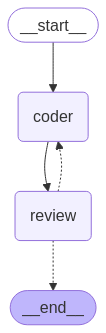

In [369]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question":"write me code to divide two numbers", "itr":0})

In [ ]:
inputs = {"question":HumanMessage(content="write me code to perform bfs in directed graph"), "itr":0}
for chunk in graph.stream(inputs, stream_mode="values"):
    print(chunk)